In [79]:
import kagglehub

path = kagglehub.dataset_download("ravidussilva/real-ai-art")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 9.95G/9.95G [02:23<00:00, 74.6MB/s]

Extracting files...


Path to dataset files: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5


Path to dataset files: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5
Model Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.94      0.84      0.89        19

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



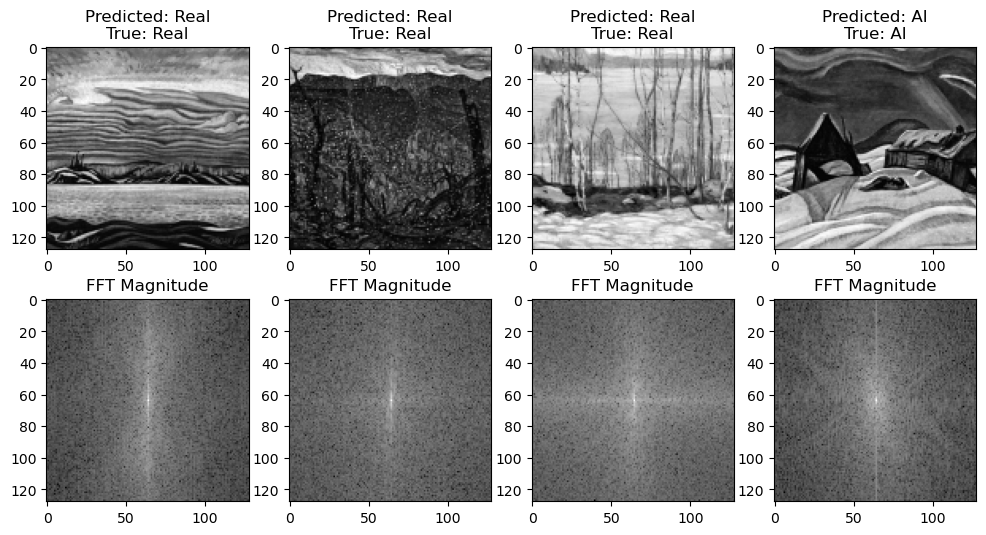

In [88]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import kagglehub


path = kagglehub.dataset_download("ravidussilva/real-ai-art")
print("Path to dataset files:", path)

# Load images and labels
def load_images(path, label, num_samples=100):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(path)):
        if i >= num_samples: break  # limit the number of samples
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Resize for consistency
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Assume subfolders "real" and "AI" contain respective images
real_images, real_labels = load_images(os.path.join(path, "Real_AI_SD_LD_Dataset\\train\\art_nouveau"), label=0)
ai_images, ai_labels = load_images(os.path.join(path, "Real_AI_SD_LD_Dataset\\train\\AI_LD_art_nouveau"), label=1)

# Combine datasets
images = np.concatenate([real_images, ai_images], axis=0)
labels = np.concatenate([real_labels, ai_labels], axis=0)

#  Apply FFT and extract frequency domain features
def fft_transform(image):
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)  # Center the frequency transform
    magnitude_spectrum = 20 * np.log(np.abs(f_shifted) + 1)  # Log scale for visibility
    return magnitude_spectrum

# Visualize FFT for sample images
def plot_fft_samples():
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, img in enumerate([real_images[0], ai_images[0]]):
        original = img
        fft_image = fft_transform(img)
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(fft_image, cmap='gray')
        axes[i, 1].set_title("FFT Magnitude")
    plt.show()

# Extract FFT features for the entire dataset
fft_images = np.array([fft_transform(img) for img in images])

# Dimensionality Reduction using PCA
fft_images_flat = fft_images.reshape(fft_images.shape[0], -1)  # Flatten for PCA
pca = PCA(n_components=50)
features = pca.fit_transform(fft_images_flat)

# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a classifier (Random Forest as an example)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)

# Visualize results
def plot_results(X_test, y_test, y_pred, test_indices):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        idx = test_indices[i]  # Use the original index
        original_img = images[idx]  # Get original image from `images`
        predicted_label = 'Real' if y_pred[i] == 0 else 'AI'
        true_label = 'Real' if y_test[i] == 0 else 'AI'
        
        # Show the original grayscale image
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title(f"Predicted: {predicted_label}\nTrue: {true_label}")
        
        # Show FFT of the original image
        fft_img = fft_transform(original_img)
        axes[1, i].imshow(fft_img, cmap='gray')
        axes[1, i].set_title("FFT Magnitude")
    
    plt.show()

# Generate test indices to access the original images
test_indices = X_test.index if hasattr(X_test, 'index') else np.arange(len(y_test))

# Call the modified plot_results function
plot_results(X_test, y_test, y_pred, test_indices)

